In [9]:
%pylab inline
#%matplotlib qt
from __future__ import division # use so 1/2 = 0.5, etc.
import sk_dsp_comm.sigsys as ss
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [10]:
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

**Import Extra Modules**

In [11]:
import sk_dsp_comm.digitalcom as dc
import sk_dsp_comm.synchronization as PLL # just in case we need it

# Part I: PCM Encoding and Decoding
The functions are housed in the module scikit-dsp-comm module `digitalcom.py.

```python
def PCM_encode(x,N_bits):
    """
    x_bits = PCM_encode(x,N_bits)
    /////////////////////////////////////////////////////////////
         x = signal samples to be PCM encoded
    N_bits = bit precision of PCM samples
    x_bits = encoded serial bit stream of 0/1 values. MSB first.
    /////////////////////////////////////////////////////////////
    Mark Wickert, March 2015
    """
    xq = np.int16(np.rint(x*2**(N_bits-1)))
    x_bits = np.zeros((N_bits,len(xq)))
    for k, xk in enumerate(xq):
        x_bits[:,k] = tobin(xk,N_bits)
    # Reshape into a serial bit stream
    x_bits = np.reshape(x_bits,(1,len(x)*N_bits),'F')
    return int16(x_bits.flatten())


# A helper function for PCM_encode
def tobin(data, width):
    data_str = bin(data & (2**width-1))[2:].zfill(width)
    return map( int, tuple( data_str ) )
    
    
def PCM_decode(x_bits,N_bits):
    """
    xhat = PCM_decode(x_bits,N_bits)
    /////////////////////////////////////////////////////////////
    x_bits = serial bit stream of 0/1 values. The length of 
             x_bits must be a multiple of N_bits
    N_bits = bit precision of PCM samples
      xhat = decoded PCM signal samples
    /////////////////////////////////////////////////////////////
    Mark Wickert, March 2015
    """
    N_samples = len(x_bits)//N_bits
    # Convert serial bit stream into parallel words with each 
    # column holdingthe N_bits binary sample value
    xrs_bits = x_bits.copy()
    xrs_bits = np.reshape(xrs_bits,(N_bits,N_samples),'F')
    # Convert N_bits binary words into signed integer values
    xq = np.zeros(N_samples)
    w = 2**np.arange(N_bits-1,-1,-1) # binary weights for bin 
                                     # to dec conversion
    for k in range(N_samples):
       xq[k] = np.dot(xrs_bits[:,k],w) - xrs_bits[0,k]*2**N_bits
    return xq/2**(N_bits-1)
    
    
def AWGN_chan(x_bits,EBN0_dB):
    """
    ////////////////////////////////////////////////////////////////////////
     x_bits = serial bit stream of 0/1 values.
    EBNO_dB = energy per bit to noise power density ratio in dB of the
              serial bit stream sent through the AWGN channel. Frequently
              we equate EBN0 to SNR in link budget calculations
     y_bits = received serial bit stream following hard decisions. This bit
              will have bit errors. To check the estimated bit error
              probability use digitalcom.BPSK_bep() or simply
              >> Pe_est = sum(xor(x_bits,y_bits))/length(x_bits);  
    ////////////////////////////////////////////////////////////////////////
    
    Mark Wickert, March 2015
    """
    x_bits = 2*x_bits - 1 # convert from 0/1 to -1/1 signal values
    var_noise = 10**(-EBN0_dB/10)/2;
    y_bits = x_bits + np.sqrt(var_noise)*np.random.randn(size(x_bits))

    # Make hard decisions
    y_bits = np.sign(y_bits) # -1/+1 signal values
    y_bits = (y_bits+1)/2 # convert back to 0/1 binary values
    return y_bits
```

**BPSK Theoretical BEP Calculation for Part I**

In [12]:
# Use the Q() function in digitalcom to find Pe_thy
EbN0_dB = 5
Pe_thy = dc.Q_fctn(sqrt(2*10**(EbN0_dB/10)))
print('Pe_thy = %1.3e' % Pe_thy)

Pe_thy = 5.954e-03


# Part I Tasks

## Task 1a and 1b

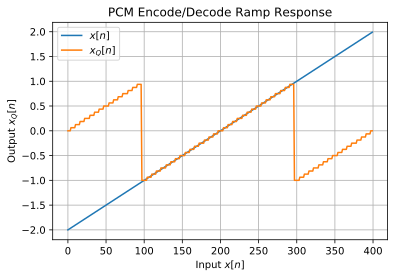

In [13]:
figure(figsize=(6,4))
n = arange(0,400)
# Fill in missing code:
x = arange(-2,2,0.01);

xbits = dc.PCM_encode(x,5)
xq = dc.PCM_decode(xbits,5)
plot(n,x)
plot(n,xq)
title(r'PCM Encode/Decode Ramp Response')
xlabel(r'Input $x[n]$')
ylabel(r'Output $x_Q[n]$')
legend((r'$x[n]$',r'$x_Q[n]$'),loc='best')
grid();

**Note**: The error above is because a line of code is missing. You will add this. 

In [14]:
def PCM_encode(x,N_bits, sat_mode = True):
    """
    Add saturation to dc.PCM_encode
    """
    
    # Write code here
    x_clip = x.clip(-1,1-2**-(N_bits-1)) #formula given in doc
    
    x_bits = dc.PCM_encode(x_clip, N_bits)
    
    return x_bits

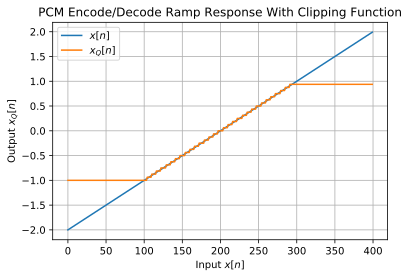

In [15]:
figure(figsize=(6,4))
n = arange(0,400)
x = arange(-2,2,0.01);
xbits = PCM_encode(x,5)
xq = dc.PCM_decode(xbits,5)
plot(n,x)
plot(n,xq)

# Added line:
title(r'PCM Encode/Decode Ramp Response With Clipping Function')

xlabel(r'Input $x[n]$')
ylabel(r'Output $x_Q[n]$')
legend((r'$x[n]$',r'$x_Q[n]$'),loc='best')
grid();

## Task 2a and 2b: Test with Speech File

In [16]:

# Include some scaling to be sure to fill the dynamic range, but not saturate
m1_max = max(abs(max(m1)), abs(min(m1)))
g = 1/m1_max

SNR_chan = 100

MSE = zeros((1,13))
for N_B in range (4,17):
    
    #g = ( 1-2**-(N_B-1) )/m1_max   #scale m1 based on max dynamic range of the quantization level
    #disp(g*m1_max)
    m1_enc = PCM_encode(g*m1,N_B)
    m1_enc_hat = dc.AWGN_chan(m1_enc,SNR_chan)

    m1_hat = dc.PCM_decode(m1_enc_hat,N_B)
    
    fname = "NB_%d.wav"%(N_B)
    ss.to_wav(fname,8000,m1_hat)

    MSE[(0,N_B-4)] = 1/size(m1)*sum((m1_hat-m1)**2)
    
figure()
scatter(arange(4,17),10*log10(1/MSE[0]))
grid()
xlabel('Number of bits')
ylabel('Inverse of mean-squared-error (dB)')
title('MSE test based on number of encoding bits');

NameError: name 'm1' is not defined

### Audio Playback:

In [ ]:
# 4 bits
Audio("NB_4.wav")

In [ ]:
# 5 bits
Audio("NB_5.wav")

In [ ]:
# 6 bits
Audio("NB_6.wav")

In [ ]:
# 7 bits
Audio("NB_7.wav")

In [ ]:
# 8 bits
Audio("NB_8.wav")

In [ ]:
# 9 bits
Audio("NB_9.wav")

In [ ]:
# 10 bits
Audio("NB_10.wav")

In [ ]:
# 11 bits
Audio("NB_11.wav")

In [ ]:
# 12 bits
Audio("NB_12.wav")

In [ ]:
# 13 bits
Audio("NB_13.wav")

In [ ]:
# 14 bits
Audio("NB_14.wav")

In [ ]:
# 15 bits
Audio("NB_15.wav")

In [ ]:
# 16 bits
Audio("NB_16.wav")

## Tasks 3a-d: Obtain SNR Data and Comments

In [ ]:
N_B = 5
SNR_chan = 100
a = PCM_encode(m1,N_B) # use your PCM_encode with clipping
a_hat = dc.AWGN_chan(a,SNR_chan)
m1_hat = dc.PCM_decode(a_hat,N_B)
# calculation to find MSE

### Compare Visually
To gain confidence in what you are doing compare the input and output waveforms via an overlay plot or by plotting the difference.

In [ ]:
plot(m1)
plot(m1_hat)
# or
#plot(m1_hat - m1)

#### Part A)

In [ ]:
# Include some scaling to be sure to fill the dynamic range, but not saturate
N_B = 8
m1_max = max(abs(max(m1)), abs(min(m1)))
g = 1/m1_max

#### Part B)

In [ ]:
# Include some scaling to be sure to fill the dynamic range, but not saturate
N_B = 6

SNR_chan = arange(0,21,1)
MSE_6 = zeros((1,size(SNR_chan)))

for ii in range (0, size(SNR_chan)):

    m1_enc = PCM_encode(g*m1,N_B)
    m1_enc_hat = dc.AWGN_chan(m1_enc,SNR_chan[ii])
    m1_hat = dc.PCM_decode(m1_enc_hat,N_B)
    
    MSE_6[(0,ii)] = 1/size(m1)*sum((m1_hat-m1)**2)

#### Part C)

In [ ]:
# Include some scaling to be sure to fill the dynamic range, but not saturate
N_B = 10

SNR_chan = arange(0,21,1)
MSE_10 = zeros((1,size(SNR_chan)))

for ii in range (0, size(SNR_chan)):

    m1_enc = PCM_encode(g*m1,N_B)
    m1_enc_hat = dc.AWGN_chan(m1_enc,SNR_chan[ii])
    m1_hat = dc.PCM_decode(m1_enc_hat,N_B)
    
    MSE_10[(0,ii)] = 1/size(m1)*sum((m1_hat-m1)**2)

#### Plots

In [ ]:
figure()
plt.plot(SNR_chan,10*log10(1/MSE_8[0]), 'k-')
plt.plot(SNR_chan,10*log10(1/MSE_6[0]), 'k--')
plt.plot(SNR_chan,10*log10(1/MSE_10[0]), 'k-.')
grid()
xlabel('SNR (dB)')
ylabel('Inverse of mean-squared-error (dB)')
title('MSE test based on SNR');
legend(('8 bits','6 bits','10 bits'));

#### Part D)

# Part II: QAM Background Examples
Begin with some functions for working with QAM. Specifically,
* `QAM_gray_encode_bb` which produces single-sample per symbol QAM waveforms and `Ns` sample per symbol waveforms with pulse shaping. Binary to Gray mapping is performed using look-up-tables (LUTs). Soon this function will be merged into `digitalcom.py` on GitHub.
* `QAM_gray_decode` which takes as input single sample per QAM symbol inputs, with noise and interference, and decodes them to a serial bit stream Gray to binary LUTs. Soon this function will be merged into `digitalcom.py` on GitHub.

## The QAM Encoder/Decoder with Gray Mapping Functions
Soon these functions will be merged into the `digitalcom.py` module on GitHub, for now they are also here in this notebook.

In [17]:
def QAM_gray_encode_bb(N_symb,Ns,M=4,pulse='rect',alpha=0.35,ext_data=None):
    """
    QAM_gray_bb: A gray code mapped QAM complex baseband transmitter 
    x,b,tx_data = QAM_gray_bb(K,Ns,M)

    //////////// Inputs //////////////////////////////////////////////////
      N_symb = the number of symbols to process
          Ns = number of samples per symbol
           M = modulation order: 2, 4, 16, 64, 256 QAM
               Note 2 <=> BPSK, 4 <=> QPSK
       alpha = squareroot raised codine pulse shape bandwidth factor.
               For DOCSIS alpha = 0.12 to 0.18. In general alpha can 
               range over 0 < alpha < 1.
       pulse = 'rect', 'src', or 'rc'
    //////////// Outputs /////////////////////////////////////////////////
           x = complex baseband digital modulation
           b = transmitter shaping filter, rectangle or SRC
     tx_data = xI+1j*xQ = inphase symbol sequence + 
               1j*quadrature symbol sequence

    Mark Wickert April 2018
    """ 
    # Create a random bit stream then encode using gray code mapping
    # Gray code LUTs for 4, 16, 64, and 256 QAM
    # which employs M = 2, 4, 6, and 8 bits per symbol  
    bin2gray1 = [0,1]
    bin2gray2 = [0,1,3,2]
    bin2gray3 = [0,1,3,2,7,6,4,5] # arange(8) 
    bin2gray4 = [0,1,3,2,7,6,4,5,15,14,12,13,8,9,11,10]
    x_m = sqrt(M)-1
    # Create the serial bit stream [Ibits,Qbits,Ibits,Qbits,...], msb to lsb
    # except for the case M = 2
    if N_symb == None:
        # Truncate so an integer number of symbols is formed
        N_symb = int(floor(len(ext_data)/log2(M)))
        data = ext_data[:N_symb*int(log2(M))]
    else:
        data = randint(0,2,size=int(log2(M))*N_symb)
    x_IQ = zeros(N_symb,dtype=complex128)
    N_word = int(log2(M)/2)
    # binary weights for converting binary to decimal using dot()
    w = 2**np.arange(N_word-1,-1,-1)
    if M == 2: # Special case of BPSK for convenience
        x_IQ = 2*data - 1
        x_m = 1
    elif M == 4: # total constellation points
        for k in range(N_symb):
            wordI = data[2*k*N_word:(2*k+1)*N_word]
            wordQ = data[2*k*N_word+N_word:(2*k+1)*N_word+N_word]
            x_IQ[k] = (2*bin2gray1[dot(wordI,w)] - x_m) + \
                   1j*(2*bin2gray1[dot(wordQ,w)] - x_m)
    elif M == 16:
        for k in range(N_symb):
            wordI = data[2*k*N_word:(2*k+1)*N_word]
            wordQ = data[2*k*N_word+N_word:(2*k+1)*N_word+N_word]
            x_IQ[k] = (2*bin2gray2[dot(wordI,w)] - x_m) + \
                   1j*(2*bin2gray2[dot(wordQ,w)] - x_m)
    elif M == 64:
        for k in range(N_symb):
            wordI = data[2*k*N_word:(2*k+1)*N_word]
            wordQ = data[2*k*N_word+N_word:(2*k+1)*N_word+N_word]
            x_IQ[k] = (2*bin2gray3[dot(wordI,w)] - x_m) + \
                   1j*(2*bin2gray3[dot(wordQ,w)] - x_m)
    elif M == 256:
        for k in range(N_symb):
            wordI = data[2*k*N_word:(2*k+1)*N_word]
            wordQ = data[2*k*N_word+N_word:(2*k+1)*N_word+N_word]
            x_IQ[k] = (2*bin2gray4[dot(wordI,w)] - x_m) + \
                   1j*(2*bin2gray4[dot(wordQ,w)] - x_m)
    else:
        raise ValueError('M must be 2, 4, 16, 64, 256')        
    
    if Ns > 1:
        # Design the pulse shaping filter to be of duration 12 
        # symbols and fix the excess bandwidth factor at alpha = 0.35
        if pulse.lower() == 'src':
            b = dc.sqrt_rc_imp(Ns,alpha,6)
        elif pulse.lower() == 'rc':
            b = dc.rc_imp(Ns,alpha,6)    
        elif pulse.lower() == 'rect':
            b = np.ones(int(Ns)) #alt. rect. pulse shape
        else:
            raise ValueError('pulse shape must be src, rc, or rect')
        # Filter the impulse train signal
        x = signal.lfilter(b,1,dc.upsample(x_IQ,Ns))
        # Scale shaping filter to have unity DC gain
        b = b/sum(b)
        return x/x_m, b, data
    else:
        return x_IQ/x_m, 1, data

In [18]:
def QAM_gray_decode(x_hat,M = 4):
    """
    Decode MQAM IQ symbols to a serial bit stream using
    gray2bin decoding
    
    x_hat = symbol spaced samples of the QAM waveform taken at the maximum
            eye opening. Normally this is following the matched filter
    
    Mark Wickert April 2018
    """
    # Inverse Gray code LUTs for 4, 16, 64, and 256 QAM
    # which employs M = 2, 4, 6, and 8 bits per symbol
    gray2bin1 = [0,1]
    gray2bin2 = [0,1,3,2]
    gray2bin3 = [0,1,3,2,6,7,5,4] # arange(8) 
    gray2bin4 = [0,1,3,2,6,7,5,4,12,13,15,14,10,11,9,8]
    x_m = sqrt(M)-1
    if M == 2: x_m = 1
    N_symb = len(x_hat)
    N_word = int(log2(M)/2)
    
    # Scale input up by x_m
#     x_hat = x_hat*x_m
    x_hat = x_hat/(std(z) * sqrt(3/(2*(M-1))))
    
    k_hat_gray = (x_hat + x_m*(1+1j))/2
    # Soft IQ symbol values are converted to hard symbol decisions
    k_hat_grayI = int16(clip(rint(k_hat_gray.real),0,x_m))
    k_hat_grayQ = int16(clip(rint(k_hat_gray.imag),0,x_m))
    data_hat = zeros(2*N_word*N_symb,dtype=int)
    # Create the serial bit stream [Ibits,Qbits,Ibits,Qbits,...], msb to lsb
    for k in range(N_symb):
        if M == 2: # special case for BPSK
            data_hat = k_hat_grayI
        elif M == 4: # total points of the square constellation
            data_hat[2*k*N_word:2*(k+1)*N_word] \
              = hstack((dc.tobin(gray2bin1[k_hat_grayI[k]],N_word),
                        dc.tobin(gray2bin1[k_hat_grayQ[k]],N_word)))
        elif M == 16:
            data_hat[2*k*N_word:2*(k+1)*N_word] \
              = hstack((dc.tobin(gray2bin2[k_hat_grayI[k]],N_word),
                        dc.tobin(gray2bin2[k_hat_grayQ[k]],N_word)))            
        elif M == 64:
            data_hat[2*k*N_word:2*(k+1)*N_word] \
              = hstack((dc.tobin(gray2bin3[k_hat_grayI[k]],N_word),
                        dc.tobin(gray2bin3[k_hat_grayQ[k]],N_word)))            
        elif M == 256:
            data_hat[2*k*N_word:2*(k+1)*N_word] \
              = hstack((dc.tobin(gray2bin4[k_hat_grayI[k]],N_word),
                        dc.tobin(gray2bin4[k_hat_grayQ[k]],N_word)))
        else:
            raise ValueError('M must be 2, 4, 16, 64, 256')  
            
    return data_hat

In [19]:
#QAM_gray_encode_bb(N_symb,Ns,M=4,pulse='rect',alpha=0.35,ext_data=None)
Ns = 16
M = 64
xbb1,b,data = QAM_gray_encode_bb(10000,Ns,M,'src')
n = arange(0,len(xbb1))
# Translate baseband to fc1/fs = 4.0/16
# Relative to Ns = 16 samps/bit & Rb = 1 bps
xc1 = xbb1*exp(1j*2*pi*4.0/Ns*n)

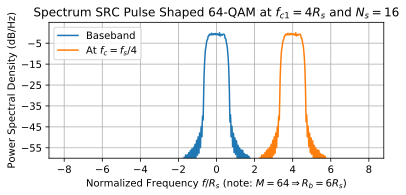

In [20]:
figure(figsize=(6,2.5))
psd(xbb1,2**10,Ns);
psd(xc1,2**10,Ns);
ylim([-60,5])
xlabel(r'Normalized Frequency $f/R_s$ (note: $M=64 \Rightarrow R_b = 6R_s$)')
legend((r'Baseband',r'At $f_c = f_s/4$'))
title(r'Spectrum SRC Pulse Shaped 64-QAM at $f_{c1} \
      = 4R_s$ and $N_s = %d$' % Ns);

## 64QAM Simulation Example

In [21]:
M = 64
Nsymb = 100000
Ns = 1 # With Ns=1 there is no need for the matched filter
EbN0_dB = 15
EsN0_dB = 10*log10(log2(M))+ EbN0_dB
print('Eb/N0 = %4.2f dB and Es/N0 = %4.2f dB' % (EbN0_dB,EsN0_dB))
xbb,b,data = QAM_gray_encode_bb(Nsymb,Ns,M,'src')
rbb = dc.cpx_AWGN(xbb,EsN0_dB,Ns)

Eb/N0 = 15.00 dB and Es/N0 = 22.78 dB


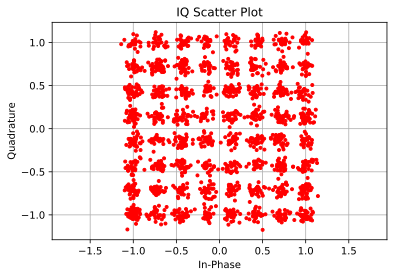

In [22]:
Npts = 2000
scat_data = rbb
plot(scat_data[:Npts].real,scat_data[:Npts].imag,'r.')
axis('equal')
title('IQ Scatter Plot')
ylabel(r'Quadrature')
xlabel(r'In-Phase')
grid();

In [23]:
data_hat = QAM_gray_decode(rbb,M)
Nbits,Nerrors = dc.BPSK_BEP(data,data_hat)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

NameError: name 'z' is not defined

In [ ]:
def MQAM_BEP(EbN0,M):
    """
    Approximate symbol error probability of MQAM
    
    Mark Wickert April 2018
    """
    if M == 2:
        PE = dc.Q_fctn(sqrt(2*EbN0))
    elif M > 2:
        EsN0 = log2(M)*EbN0 # convert Eb/N0 to Es/N0
        PE = 4*(1 - 1/sqrt(M))*dc.Q_fctn(sqrt(3/(M-1)*EsN0))/log2(M)
    return PE

* Let's check the simulation results above against theory:

In [ ]:
P_e_thy = MQAM_BEP(10**(EbN0_dB/10),64)
print('P_e_bit_thy = %4.2e' % P_e_thy)

* Yes, the results are close

## Waveform Level Simulation

In [ ]:
M = 64
Nsymb = 500
Ns = 10 # With Ns=10 we have a waveform
EbN0_dB = 100 # Make the addive noise negligible for now
EsN0_dB = 10*log10(log2(M)) + EbN0_dB # Convert Eb/N0 to Es/N0
print('Eb/N0 = %4.2f dB and Es/N0 = %4.2f dB' % (EbN0_dB,EsN0_dB))
xbb,b,data = QAM_gray_encode_bb(Nsymb,Ns,M,'rect')
# Enter the comm channel by adding noise
rbb = dc.cpx_AWGN(xbb,EsN0_dB,Ns)

In [ ]:
Nplot = 100
subplot(211)
plot(rbb[:Nplot*Ns].real*7) # Remove the unity amplitude scaling to see the +/-1, +/-3, ...
ylabel(r'Amplitude')
xlabel(r'Sample Index $n$')
title(r'Scaled Inphase or $I[n]$ Signal Transmitted at Baseband')
subplot(212)
plot(rbb[:Nplot*Ns].imag*7)
ylabel(r'Amplitude')
xlabel(r'Sample Index $n$')
title(r'Scaled Quadrature or $Q[n]$ Signal Transmitted at Baseband')
tight_layout()

### Including the Receiver Matched Filter to Mitigate Noise
Take the received waveform into the receiver by first passing the signal through the *matched filter* `b`, which is conveniently returned by `QAM_gray_encode_bb`. 

In [ ]:
# Enter the receiver by passing through the matched filter
# Note carrier frequency ofset and phase tracking would likely be needed, but here
# both are zero to keep things simple.
y = signal.lfilter(b,1,rbb)

### Choosing the Proper Once Per Symbol Sampling Instant
The symbol synchronization operation requires sampling the matched filter output onnce per symbol such that the maximum SNR is achieved, and hence the minimum BEP is obtained. Here we use `ss.downsample(y,Ns,phase)` to do this. The optional third argument `phase`, chosen from [0,Ns-1], which is exactly what we need. In practice a PLL symbol synchronizer performs this automatically. 

In [ ]:
# Symbol synchronize manually
z = ss.downsample(y,Ns,9)
figure(figsize=(6,3))
plot(z[:2*Nplot].real*7,'r.') # Again scale to see that the sample values are aligning 
                              # with the expected unscaled tx values.
title(r'Scaled Optimal Symbol Spaced Samples')
ylabel(r'Inphase Symbol Samples')
xlabel(r'Sample Index')
grid();

We can use the `eyeplot` function to get a better handle on the options.

In [ ]:
dc.eye_plot(y.real,2*Ns,12*Ns) # The 12*Ns removed the pulse shaping filter transients
plot([9,9],[-1.2,1.2],'g--')
title(r'Eyeplot of Inphase with Rect Pulse Shaping')

### Quick Look with SRC Pulse Shaping
Change from the easy to visualize rectangular pulse shape to the square-root raised cosine (`src`) shape, which has a very compact spectrum. Here in particular the optimum sampling instant shifts from `phase = 9` to `phase = mod(10,Ns) = 0`.

In [ ]:
M = 64
Nsymb = 100000
Ns = 40 # With Ns=10 we have a waveform
EbN0_dB = 50 # Make the addive noise negligible for now
EsN0_dB = 10*log10(log2(M)) + EbN0_dB
print('Eb/N0 = %4.2f dB and Es/N0 = %4.2f dB' % (EbN0_dB,EsN0_dB))
xbb,b,data = QAM_gray_encode_bb(Nsymb,Ns,M,'src')
# Enter the comm channel by adding noise
rbb = dc.cpx_AWGN(xbb,EsN0_dB,Ns)
# Enter the receiver by passing through the matched filter
# Note carrier frequency offset and phase tracking would likely be needed, but here
# both are zero to keep things simple.
y = signal.lfilter(b,1,rbb)
# Timeout for an eye plot to check timing
figure(figsize=(6,2))
dc.eye_plot(y[:10000].real,2*Ns,12*Ns) # 12*Ns removes the filter transients
plot([0,0],[-1.2,1.2],'g--')
plot([10,10],[-1.2,1.2],'g--')
title(r'Eyeplot of Inphase with SRC Pulse Shaping')
# Symbol synchronize manually
z = ss.downsample(y,Ns,1)
figure(figsize=(6,3))
# Scale so the peak is +/- (sqrt(M) - 1).
plot(z[:2*Nplot].real/(std(z) * sqrt(3/(2*(M-1)))),'r.') 
title(r'Scaled Optimal Symbol Spaced Samples')
ylabel(r'Inphase Symbol Samples')
xlabel(r'Sample Index')
ylim([-8,8])
grid();
tight_layout()

### BEP Testing with Waveforms
Here we feed the reference bit stream output, `data`, from `QAM_gray_encode_bb` along with the decoded bit stream `QAM_gray_decode` into `BPSK_BEP`. For the SRC pulse shaped waveform the net filter delay from the encoder and the matched filter is 12 symbols. A cross-correlation is performed inside `BPSK_BEP` to align the two input bit streams for error detection. This of course assumes the are not too many errors.

In [ ]:
data_hat = QAM_gray_decode(z,M)
Nbits,Nerrors = dc.BPSK_BEP(data,data_hat)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

Zero bit errors at high SNR ($E_b/N_0$) is the expected result.

## End-to-End Audio Test
The objective is to send audio through the 64QAM link using the PCM encoder/decoder pair. Some timing adjustment is needed to:

1. Make sure the filtering transient is properly removed at the start of the received serial bit stream
2. The number of bits processed bby `PCM_decode` is an integer multiple of the PCM word length in bits

We will also see how `QAM_gray_encode_bb` can work with an externally supplied bit stream, as opposed to its internally generated random bit stream.

In [ ]:
Nstart = 20000
N = 60000; # number of speech samples to process
fs,m1 = ss.from_wav('OSR_uk_000_0050_8k.wav')
m1 = 2*m1[Nstart:Nstart+N]
N_PCM = 8 # PCM encode with 8 bits per audio sample
data_ext = dc.PCM_encode(m1,N_PCM) # Obtain external data bits for QAM_gray_encode
M = 64 # QAM modulate using a 64 point constellation (8x8 points)
Ns = 10 # With Ns=10 we have a waveform
EbN0_dB = 100 # Make the addive noise negligible for now
EsN0_dB = 10*log10(log2(M)) + EbN0_dB
print('Eb/N0 = %4.2f dB and Es/N0 = %4.2f dB' % (EbN0_dB,EsN0_dB))
xbb,b,data_ext_trim = QAM_gray_encode_bb(None,Ns,M,'src',ext_data=data_ext)
# Enter the comm channel by adding noise
rbb = dc.cpx_AWGN(xbb,EsN0_dB,Ns)
# Enter the receiver by passing through the matched filter
# Note carrier frequency offset and phase tracking would likely be needed, but here
# both are zero to keep things simple.
y = signal.lfilter(b,1,rbb)
# Symbol synchronize manually
z = ss.downsample(y,Ns,0)
data_ext_hat = QAM_gray_decode(z,M)
Nbits,Nerrors = dc.BPSK_BEP(data_ext_trim,data_ext_hat)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
      (Nbits, Nerrors, Nerrors/Nbits))

In [ ]:
plot(z[2000:2100].real*7,'r.')
ylim([-8,8])
title(r'Scaled Optimal Symbol Spaced Samples')
ylabel(r'Inphase Symbol Samples')
xlabel(r'Sample Index')
grid();

As we get ready to decode the recovered/demodulated bit stream `data_ext_hat` we have to bear in mind the signal imposed by the two SRC pulse shaping filters. Why? Bits that enter the PCM decoder must be properly framed, that is `N_PCM` is the word length, in this case 8 bits, so the word boundaries have to align for the decoder the do its job.

A clue that delay has occured is to look at the `taumax` output from the BEP functioin. In the above example we see `taumax = 72`, which says that the cross-correlation detection in `BPSK_BEP` found achieved its maximum by lagging the reference bits from the transmitter (`data_ext_trim`) by 72 bits. The default pulse shaping filter, `b`, introduces a delay of 6 symbols as does the matched filter in the receiver. Hence a total delay of 12 symbols is introduced. For $M=64$ QAM we transmit 6 bits per symbol. The total delay in bits is thus $6\times 12 = 72$.

The concern is this delay an integer multiple of $N_\text{PCM} = 8$? Yes, as $72/8 = 9$.

In [ ]:
72//8

Great, we do not have to do any bit trimming at the front of `data_ext_hat`. We do have to make sure that the length of `data_ext_hat` is an integer multiple of `N_PCM`. We can automate this as shown below, and while we are at it trim some of the spurious bits being pushed out of the *bit pipe* due to the delay.

In [ ]:
N_offset = 8*9
data_ext_hat_trim = data_ext_hat[N_offset:\
                                 N_offset+N_PCM*int(len(data_ext_hat)/N_PCM)]
m1_hat = dc.PCM_decode(data_ext_hat_trim,N_PCM)
subplot(211)
plot(m1_hat)
ylabel(r'Speech Amplitude')
xlabel(r'Sample Index at 8 ksps')
title(r'A Portion of OSR_uk_000_0050_8k.wav')
N_offset = 8*9
# Improperly trim so that the word bondary is shifted by 5 bits
m1_hat_miss = dc.PCM_decode(data_ext_hat_trim[5:-3],N_PCM)
subplot(212)
plot(m1_hat_miss)
ylabel(r'Speech Amplitude')
xlabel(r'Sample Index at 8 ksps')
title(r'A Portion of OSR_uk_000_0050_8k.wav with Align Error')
tight_layout()

In [ ]:
ss.to_wav('QAM_PCM.wav',8000,m1_hat)
Audio('QAM_PCM.wav')

Compare input and output bit streams by trimming off the first 72 bits using the `strips()` plot function found in `digitalcom`:

In [ ]:
dc.strips(data_ext[1000:1000+800],9*8,fig_size=(6,3)) # 9 N_PCM = 8-bit frames per strip
title(r'The Transmitted Bit Stream 1000 Bits into the Stream')

In [ ]:
dc.strips(data_ext_hat[1000+advance:1000+800+advance],9*8,fig_size=(6,3))
title(r'The Received Bit Stream 1000 Bits into the Stream')

The above confirms what was suspected from the start. We see the second strip of 72 bits in the second plot matches the first strip of 72 bits from the first plot. The spurious seen in the first row of the second plot consist of all but 4 zeros. Recall a total of 12 64-QAM Symbols is equivalent to 72 bits, and this is also a multiple of `N_PCM`, so all is well on the playback of the audio too.

# Part 2 Tasks

## Task 4a

In [ ]:
M = 64
Nsymb = 100000
Ns = 1 # With Ns=1 there is no need for the matched filter
EbN0_dB = 15
EsN0_dB = 10*log10(log2(M))+ EbN0_dB
print('Eb/N0 = %4.2f dB and Es/N0 = %4.2f dB' % (EbN0_dB,EsN0_dB))
xbb,b,data = QAM_gray_encode_bb(Nsymb,Ns,M,'src')

# Enter the comm channel by adding noise
rbb = dc.cpx_AWGN(xbb,EsN0_dB,Ns)
Eb/N0 = 15.00 dB and Es/N0 = 22.78 dB

# Plot the 64-QAM constellation points as a scatter plot
Npts = 2000
scat_data = rbb
plot(scat_data[:Npts].real,scat_data[:Npts].imag,'r.')
axis('equal')
title('IQ Scatter Plot')
ylabel(r'Quadrature')
xlabel(r'In-Phase')
grid();

# Decode the QAM symbols back to a serial bit stream
data_hat = QAM_gray_decode(rbb,M)
Nbits,Nerrors = dc.BPSK_BEP(data,data_hat)
print('BEP: Nbits = %d, Nerror = %d, Pe_est = %1.3e' % \
 (Nbits, Nerrors, Nerrors/Nbits))

## Task 4b

In [ ]:
# Sample BEP Plot
figure(figsize=(6,6))
EbN0_dB_plot = arange(0,25.6,0.5)
Pe_thy_plotM2 = MQAM_BEP(10**(EbN0_dB_plot/10),2)
semilogy(EbN0_dB_plot,Pe_thy_plotM2)
ylim([1e-6,1e-1])
xlim([0,25])
ylabel(r'Probability of Bit Error')
xlabel(r'Received $E_b/N_0$ (dB)')
title(r'BPSK (M=2) BEP')
legend((r'M = 2',),loc='best')
grid();

## Task 4c
Write your explanation here.

## Task 5a

### Add Some Gaussian Noise and Phase Noise

In [ ]:
...
EbN0_dB = 15
EsN0_dB = 10*log10(log2(M))+ EbN0_dB
print('Es/N0 = %4.2f (dB)' % EsN0_dB)
rbb = dc.cpx_AWGN(x_IQ_scaled,EsN0_dB,1)
std_pn_deg = 0.1
rbb_pn = rbb*exp(1j*2*pi*std_pn_deg*randn(len(x_IQ_scaled))/360)
...

## Task 6a

## Task 6b

## Task 7